# Models from the R stemming process

**NB: GIULIO runned this script with the optimal parameters obtained in the hyperparameter tuning phase**

In [2]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
data = pd.read_csv('../../datasets/data-stemmed-R.csv')
Y = data['engagement.rate']
X = data.drop(columns=['engagement.rate'])
columns_to_scale= ['quotes','user.tweets','user.following','user.media'] 
scaler = StandardScaler()
X[columns_to_scale]= scaler.fit_transform(X[columns_to_scale]) 

In [5]:
def CVTest(model, str_model, X, Y, data, reg_metrics: pd.DataFrame, n_splits = 10, top_n_features = 25):
    kf = KFold(n_splits, shuffle=True)
    feature_names= data.drop(columns=['engagement.rate']).columns.tolist()   # Get list of feature names from the dataframe
    total_feature_importance = np.zeros(len(X.columns.tolist()))   # Initialize array to hold feature importances
    for train_index, test_index in kf.split(X):
        start_learn = time.time()
        model.fit(X.iloc[train_index], Y.iloc[train_index])
        end_learn = time.time()
        exe_time_learn = end_learn - start_learn

        # Feature importance calculation for applicable models
        if hasattr(model, 'feature_importances_'):
            feature_importance = model.feature_importances_
            total_feature_importance += feature_importance  # Accumulate feature importance for mean calculation
        else:
            print("This model does not provide feature importances.")
        
        start_pred = time.time()
        Y_pred = model.predict(X.iloc[test_index])
        end_pred = time.time()
        exe_time_pred = end_pred - start_pred

        current_mae = mean_absolute_error(Y.iloc[test_index], Y_pred)
        current_mse = mean_squared_error(Y.iloc[test_index], Y_pred)
        current_rmse = mean_squared_error(Y.iloc[test_index], Y_pred, squared=False)
        reg_metrics.loc[len(reg_metrics)] = [str_model.upper(), current_mae, current_mse, current_rmse, exe_time_learn, exe_time_pred]
    
    # Calculate mean importance over all folds
    mean_feature_importance = total_feature_importance / n_splits
    importance_df = pd.DataFrame({'Feature': feature_names, 'Mean Importance': mean_feature_importance})
    top_features = importance_df.nlargest(top_n_features, 'Mean Importance')
    print(f"Top {top_n_features} features based on mean importance over all folds:")
    print(top_features[['Feature', 'Mean Importance']])


In [6]:
reg_metrics_text = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'TIME_LEARN', 'TIME_PREDICT'])

This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
Top 25 features based on mean importance over all folds:
                     Feature  Mean Importance
0                    chicken              0.0
1                   fastfood              0.0
2                       fire              0.0
3                       food              0.0
4                      foodi              0.0
5                    foodpic              0.0
6                        fri              0.0
7                   homecook              0.0
8      homecookingvsfastfood           

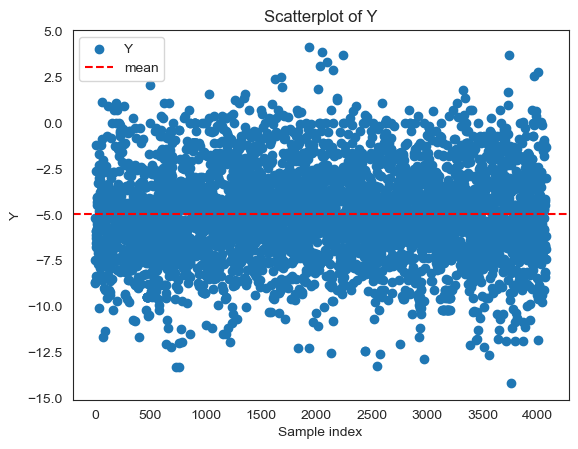

In [107]:
dummy = DummyRegressor()
CVTest(dummy, 'dummy', X, Y, data, reg_metrics_text)

#Scatterplot of Y
mean_y = np.mean(Y)
plt.scatter(np.arange(len(Y)), Y, label='Y')
plt.axhline(y=mean_y, color='r', linestyle='--', label='mean')    # Plot the mean
plt.title('Scatterplot of Y')
plt.xlabel('Sample index')
plt.ylabel('Y')
plt.legend()
plt.show()

In [108]:
# Decision Tree Regressor
# Initialize a decision tree regressor instance
tree_regressor = DecisionTreeRegressor(min_samples_split=101)    # Try tuning on the hyperparameters: max_depth, min_samples_leaf, min_samples_split
CVTest(tree_regressor, 'tree', X, Y, data, reg_metrics_text)

Top 25 features based on mean importance over all folds:
                Feature  Mean Importance
278         user.tweets         0.435075
279      user.following         0.208880
280          user.media         0.126275
268              quotes         0.104446
269          is.retweet         0.042695
277        user.website         0.019084
14                  yum         0.010225
281          n_hashtags         0.009526
271            pictures         0.003782
64                 link         0.002540
28                 time         0.001680
194  httpssecondscomtip         0.001559
98                 life         0.001495
3                  food         0.001469
232         foodstagram         0.001285
186          agricultur         0.001156
55                avail         0.000971
211               thank         0.000963
78                india         0.000928
1              fastfood         0.000889
20             culinari         0.000887
154             countri         0.000846


In [7]:
# Random Forest Regressor
# Initialize a random forest regressor instance
rf_regressor = RandomForestRegressor(random_state=42, n_jobs=-1,
                                     max_features=X.shape[1] // 3, min_samples_split=2, n_estimators=500)   # Try tuning on the hyperparameters: n_estimators, max_depth, min_samples_leaf, min_samples_split
CVTest(rf_regressor, 'rf', X, Y, data, reg_metrics_text)

Top 25 features based on mean importance over all folds:
                 Feature  Mean Importance
278          user.tweets         0.236773
279       user.following         0.198596
280           user.media         0.164818
268               quotes         0.071429
269           is.retweet         0.029413
281           n_hashtags         0.025239
277         user.website         0.023638
282              n_emoji         0.007954
274  multimedial_content         0.007349
3                   food         0.006327
276             user.bio         0.005748
271             pictures         0.005376
272               videos         0.003216
14                   yum         0.002961
194   httpssecondscomtip         0.002716
0                chicken         0.002585
4                  foodi         0.002360
255             icecream         0.002291
16                  face         0.002284
97                   eat         0.002271
26                 recip         0.002097
211                

In [110]:
svr_linear_regressor = SVR(kernel='linear',C=0.005) 
CVTest(svr_linear_regressor, 'svm_lin', X, Y, data, reg_metrics_text)

svr_poly_regressor = SVR(kernel='poly',C=0.1, degree=2) 
CVTest(svr_poly_regressor, 'svm_poly', X, Y, data, reg_metrics_text)

svr_rbf_regressor = SVR(kernel='rbf',C=5,gamma='scale') 
CVTest(svr_rbf_regressor, 'svm_rbf', X, Y, data, reg_metrics_text)

This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
Top 25 features based on mean importance over all folds:
                     Feature  Mean Importance
0                    chicken              0.0
1                   fastfood              0.0
2                       fire              0.0
3                       food              0.0
4                      foodi              0.0
5                    foodpic              0.0
6                        fri              0.0
7                   homecook              0.0
8      homecookingvsfastfood           

In [111]:
knn_regressor = KNeighborsRegressor(n_neighbors=20)       #Try tuning on the hyperparameters: n_neighbors, weights
CVTest(knn_regressor, 'knn', X, Y, data, reg_metrics_text)

This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
Top 25 features based on mean importance over all folds:
                     Feature  Mean Importance
0                    chicken              0.0
1                   fastfood              0.0
2                       fire              0.0
3                       food              0.0
4                      foodi              0.0
5                    foodpic              0.0
6                        fri              0.0
7                   homecook              0.0
8      homecookingvsfastfood           

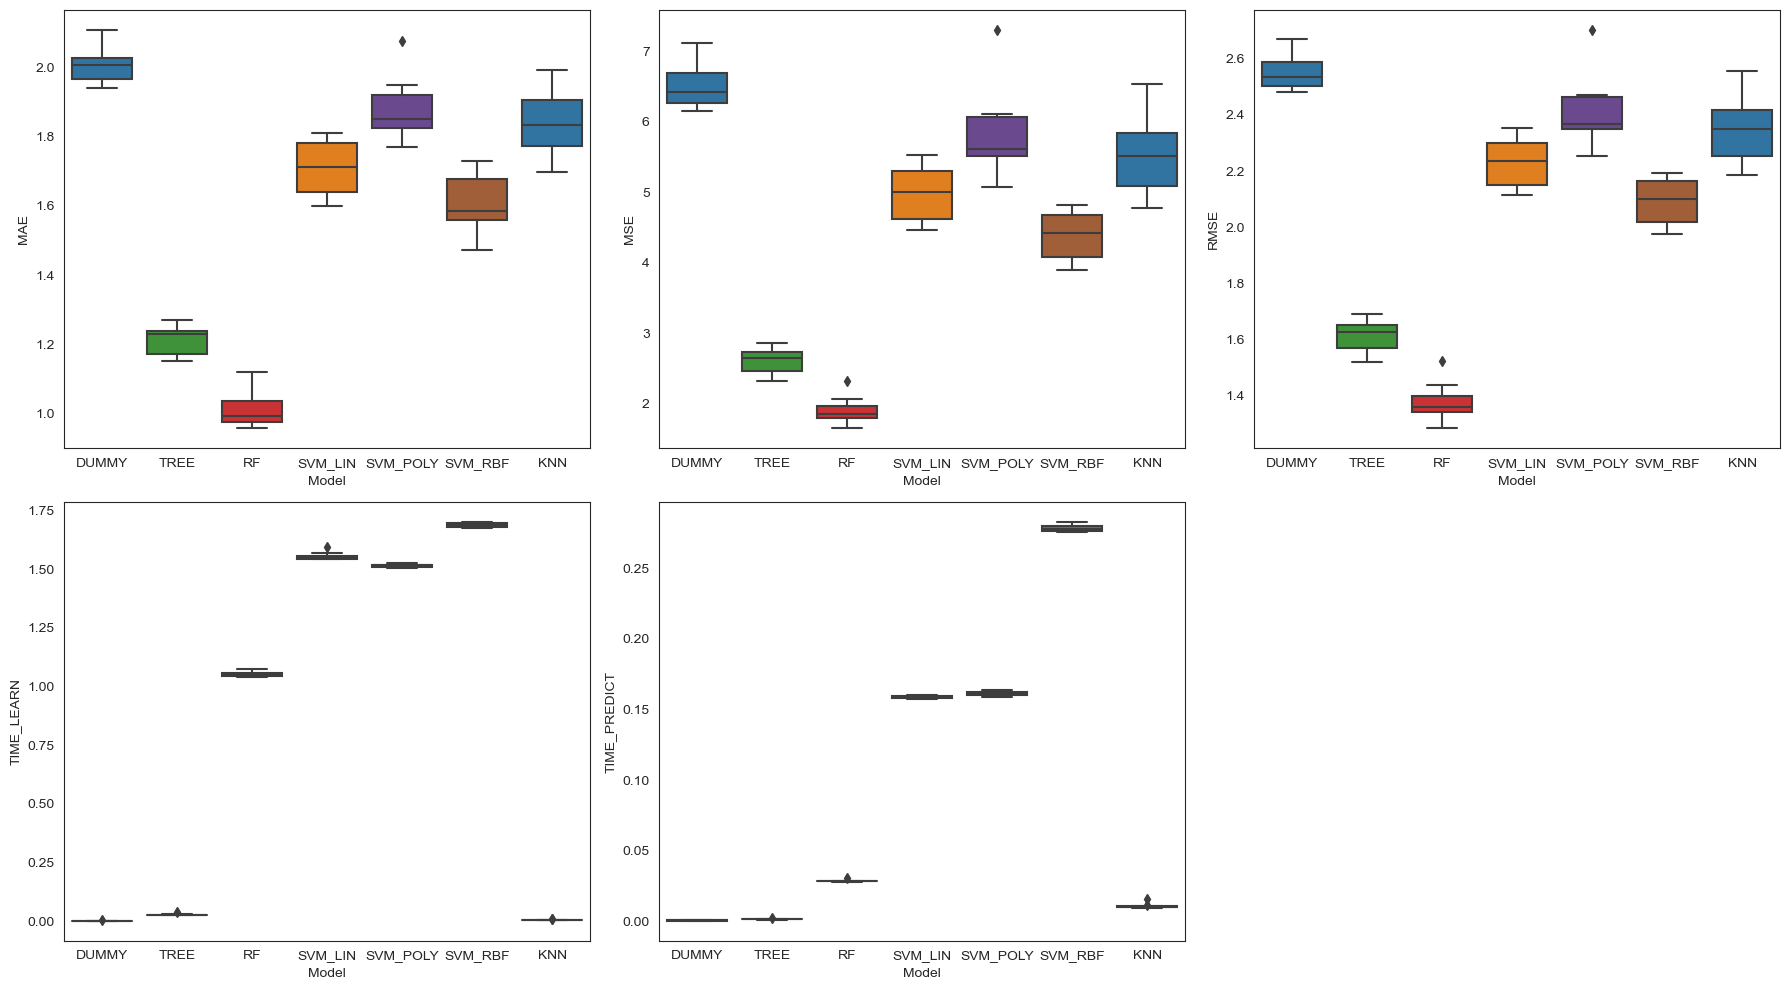

user.tweets


In [112]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
sns.boxplot(data=reg_metrics_text, x="Model", y="MAE", ax=axs[0, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_text, x="Model", y="MSE", ax=axs[0, 1], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_text, x="Model", y="RMSE", ax=axs[0, 2], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_text, x="Model", y="TIME_LEARN", ax=axs[1, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_text, x="Model", y="TIME_PREDICT", ax=axs[1, 1], palette=sns.color_palette('Paired')[1::2])

# Hide the empty subplot (if any)
axs[1, 2].axis('off')



plt.tight_layout()
plt.show()

print(X.columns[278])

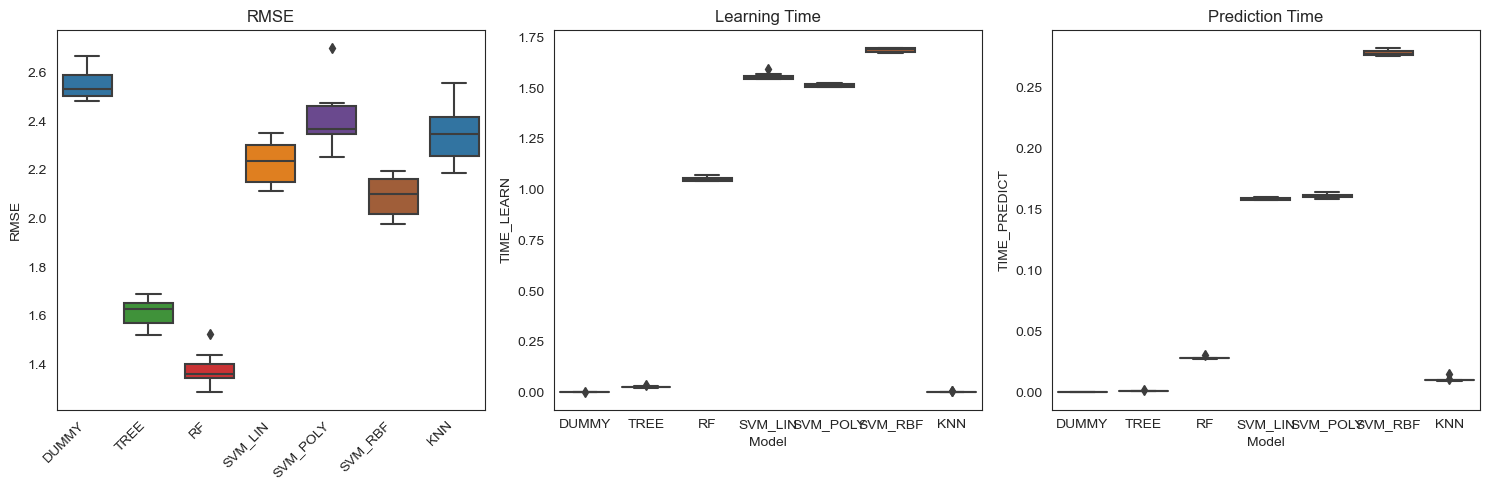

In [113]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.set_style('white')
# Boxplot for RMSE

sns.boxplot(data=reg_metrics_text, x="Model", y="RMSE", ax=axs[0], palette=sns.color_palette('Paired')[1::2])
axs[0].set_title('RMSE')
axs[0].set_xlabel('') 
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right') 
#add legend with type of technique
# Boxplot for TIME_LEARN
sns.boxplot(data=reg_metrics_text, x="Model", y="TIME_LEARN", ax=axs[1], palette=sns.color_palette('Paired')[1::2])
axs[1].set_title('Learning Time')
#axs[1].set_ylim(0, 2)  # Set the y-axis limits to [0, 1]
# Boxplot for TIME_PREDICT
sns.boxplot(data=reg_metrics_text, x="Model", y="TIME_PREDICT", ax=axs[2], palette=sns.color_palette('Paired')[1::2])
axs[2].set_title('Prediction Time')

# Adjust layout
plt.tight_layout()
# Show the plot
plt.show()
fig.savefig('../../plots/techniques_comparison.png')

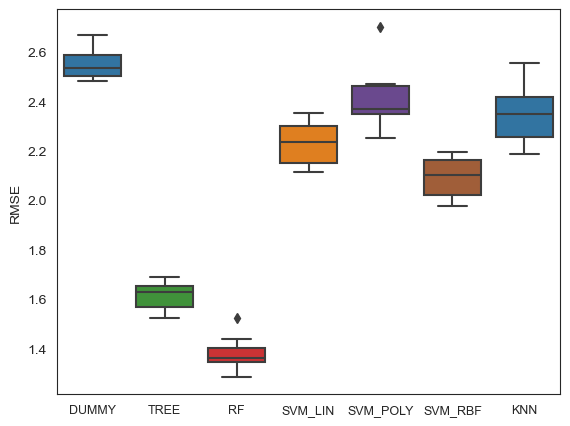

In [121]:
fig = plt.figure(figsize=(6.5, 5))


sns.set_style("white")
# Assuming reg_metrics_text is your DataFrame
sns.boxplot(data=reg_metrics_text, x="Model", y="RMSE", palette=sns.color_palette('Paired')[1::2])
plt.xticks(fontsize=9)
plt.xlabel('')
# Show the plot
plt.show()
fig.savefig('../../plots/techniques_comparison_rmse.png')


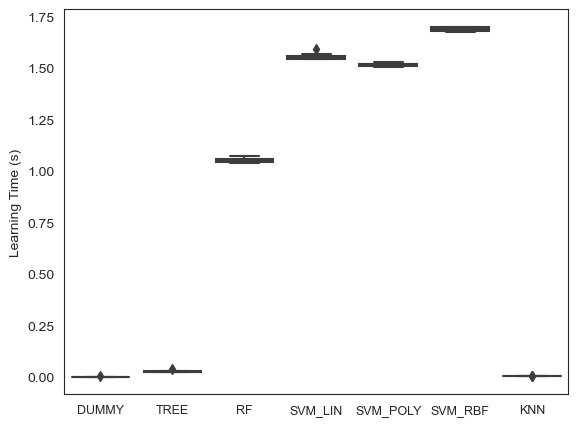

In [122]:
fig = plt.figure(figsize=(6.5, 5))


sns.set_style("white")
# Assuming reg_metrics_text is your DataFrame
sns.boxplot(data=reg_metrics_text, x="Model", y="TIME_LEARN", palette=sns.color_palette('Paired')[1::2])
plt.xticks(fontsize=9)
plt.xlabel('')
plt.ylabel('Learning Time (s)')
# Show the plot
plt.show()
fig.savefig('../../plots/techniques_comparison_time_learn.png')

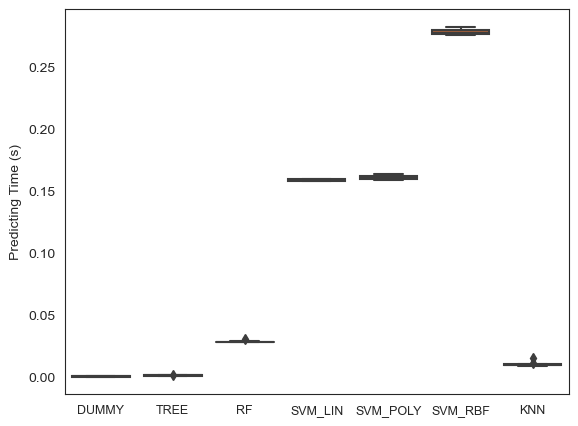

In [124]:
fig = plt.figure(figsize=(6.5, 5))
sns.set_style("white")
# Assuming reg_metrics_text is your DataFrame
sns.boxplot(data=reg_metrics_text, x="Model", y="TIME_PREDICT", palette=sns.color_palette('Paired')[1::2])
plt.xticks(fontsize=9)
plt.xlabel('')
plt.ylabel('Predicting Time (s)')
# Show the plot
plt.show()
fig.savefig('../../plots/techniques_comparison_time_predict.png')

In [ ]:
reg_metrics_text.groupby('Model').agg({'RMSE' : ['mean','std'],
                                       'TIME_LEARN' : ['mean','std'],
                                       'TIME_PREDICT' : ['mean','std']
                                       })